In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import GCRCatalogs

%matplotlib inline

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Extract DM haloes from the SkySim catalog in a given mass and redshift range. 

## Get catalog information: cosmology, sky area and define cuts

In [3]:
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')
cosmo_ss  = skysim_cat.cosmology

In [4]:
print(cosmo_ss)
print(skysim_cat.sky_area)

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)
57.071968


In [5]:
zmin = 0.
zmax = 1.
mmin = 1.e14 # Msun. 
mmax = 1.e15 # Msun

## Perform extraction
**NB: This may be skipped if using directly the files in the `data` directory**

In [6]:
# Get list of halos in a given redshift and mass range.
# Can only filter on 'halo_mass' which corresponds to the fof mass (in Msun).
# Will extract all haloes with halo_mass > mmin_extract now
# and refine the mass range on M200c, afterwards

mmin_extract = 1.e12 # Msun (M_fof)
dm_halos = skysim_cat.get_quantities(['halo_mass','redshift','baseDC2/sod_halo_mass'],
                                     filters=[f'halo_mass > {mmin_extract}','is_central==True',
                                              f'redshift>{zmin}', f'redshift<{zmax}'])
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos in this mass (Mfof) and redshift range')

There are 300879 halos in this mass (Mfof) and redshift range


### Define a redshift and mass range
NB: SkySim5000 M200c masses are in units of Msun/h

In [7]:
dm_halos['M200c'] = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h # sod_halo_mass = M200,c in Msun/h, needs conversion

filt3 = dm_halos['M200c'] >= mmin
filt4 = dm_halos['M200c'] < mmax
filt = filt3 * filt4

data_m_ss = dm_halos['M200c'][filt] # M200,c [Msun]
data_z_ss = dm_halos['redshift'][filt]

# Set up NumCosmo cosmology

In [8]:
Ncm.cfg_init ()
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new () 
prim = Nc.HIPrimPowerLaw.new () 

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

dist = Nc.Distance.new (2.0)

tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

In [9]:
cosmo.props.H0      = cosmo_ss.H0.value
cosmo.props.Omegab  = cosmo_ss.Ob0
cosmo.props.Omegac  = cosmo_ss.Odm0
cosmo.props.Omegax  = cosmo_ss.Ode0

cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("Omegak", 0.0)

prim.props.n_SA = cosmo_ss.n_s
print(cosmo_ss.sigma8,cosmo.sigma8(psf),cosmo.Omega_k0())

old_amplitude = math.exp (prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log ((cosmo_ss.sigma8 / cosmo.sigma8(psf))**2 * old_amplitude)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))


0.8 0.8490796381181809 0.0
0.8 0.8000000000000003


# Set up fit with NumCosmo

## Mass function, mass and redshift distributions

In [10]:
#
# New multiplicity function 'NcMultiplicityFuncTinkerMean'
#
mulf = Nc.MultiplicityFuncTinker.new ()
#mulf = Nc.MultiplicityFuncBocquet.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
#
# New mass function object using the objects defined above.
#
mf = Nc.HaloMassFunction.new (dist, psf, mulf)

#mf.set_area_sd (skysim_cat.sky_area) # Not sure if this is the way to setup a sky area

In [11]:
#
# New Cluster Mass object
#
lnM_min = math.log (mmin)
lnM_max = math.log (mmax)

# using Log normal distribution
#cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassLnnormal{'lnMobs-min':<%20.15e>, 'lnMobs-max':<%20.15e>}" % (lnM_min, lnM_max))
#cluster_m.props.bias       = 0.0
#cluster_m.props.sigma      = 0.2
#print(cluster_m.lnMobs_min, cluster_m.lnMobs_max, lnM_min, lnM_max)

# no distribution - assumes masses are perfectly known
cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (lnM_min, lnM_max))
print(cluster_m.lnM_min, cluster_m.lnM_max, lnM_min, lnM_max)

32.23619130191664 34.53877639491068 32.23619130191664 34.538776394910684


In [12]:
#
# New Cluster Redshift object
#

# using a global gaussian distribution
#cluster_z = Nc.ClusterRedshift.new_from_name ("NcClusterPhotozGaussGlobal{'pz-min':<%20.15e>, 'pz-max':<%20.15e>, 'z-bias':<0.0>, 'sigma0':<0.03>}" % (zmin, zmax))

# no distribution - assumes redshifts are perfectly known
cluster_z = Nc.ClusterRedshiftNodist(z_min = zmin, z_max=zmax)
print(cluster_z.z_min, cluster_z.z_max, zmin, zmax)

0.0 1.0 0.0 1.0


## Set up objects for the fit

In [13]:
#
# New Cluster abundance object that uses all objects above
#
cad = Nc.ClusterAbundance.new (mf, None)

#
# New NcmData object for number count calculations
#
ncdata = Nc.DataClusterNCount.new (cad)

#
#  Creating a new Modelset and set cosmo as the HICosmo model to be used
#  and cluster_m as the distribution of the mass-observable relation
#
mset = Ncm.MSet.new_array ([cosmo, cluster_z, cluster_m])

In [14]:
#
# Fill ncdata with SkySim masses and redshifts
#

ncdata.set_n_z_obs (1)
ncdata.set_n_z_obs_params (0)
ncdata.set_n_M_obs (1)
ncdata.set_n_M_obs_params (0)

ncdata.set_lnM_true(Ncm.Vector.new_array(np.log (data_m_ss)))
ncdata.set_z_true(Ncm.Vector.new_array(data_z_ss))

# Because we are using true masses and redshifts in this example,
# we replicate the true data in the 'observed' masses and redshift attributes
ncdata.set_lnM_obs (Ncm.Matrix.new_array (data_m_ss,1))
ncdata.set_z_obs (Ncm.Matrix.new_array (data_z_ss,1))

#ncdata.props.area = skysim_cat.sky_area
mf.set_area_sd (skysim_cat.sky_area)

ncdata.true_data (True)
ncdata.set_init(True)

# #
# # Save to a fits file
# #
ncdata.catalog_save ("skysim5000_data.fits", True)

In [15]:
# If the catalog already exists, skip previous step and load it directly

# ncdata.catalog_load("../data/skysim5000_data.fits")

## Define free parameters and prepare likelihood

In [16]:
cosmo.props.Omegac_fit    = True
cosmo.props.Omegab_fit    = False
prim.props.ln10e10ASA_fit = True

# data set
dset = Ncm.Dataset.new ()
dset.append_data (ncdata)


# New likelihood object using dset
lh = Ncm.Likelihood.new (dset)


## Fit for parameters (Omegac, ln10e10ASA) --> (Omegam, sigma8)

### Simple fit

In [17]:
#
#  Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to
#  fit the Modelset mset using the Likelihood lh and using a numerical differentiation
#  algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).
#
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run (Ncm.FitRunMsgs.SIMPLE)

#
# Printing fitting informations.
#
fit.log_info ()
fit.obs_fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:14.0228900
#  iteration            [000077]
#  function evaluations [000079]
#  gradient evaluations [000000]
#  degrees of freedom   [000624]
#  m2lnL     =     44.1286155859934 (     44.128616 )
#  Fit parameters:
#     0.211845890178938    3.16647852673646    
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -       

In [18]:
print (cosmo.props.Omegac, cosmo_ss.Odm0)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))

0.2118458901789377 0.21999999999999997
0.8 0.8221088861828266


### MCMC

In [19]:
#
# Setting single thread calculation.
#
Ncm.func_eval_set_max_threads (5)
Ncm.func_eval_log_pool_stats ()

#
# Additional functions as we want the chains for sigma8 and Omegam, which are derived parameters
#
mfunc_oa = Ncm.ObjArray.new ()

mfunc_sigma8 = Ncm.MSetFuncList.new ("NcHICosmo:sigma8", psf)
mfunc_Omegam = Ncm.MSetFuncList.new ("NcHICosmo:Omega_m0", None)

mfunc_oa.add (mfunc_sigma8)
mfunc_oa.add (mfunc_Omegam)

print (mfunc_sigma8.eval0 (mset))
print (mfunc_Omegam.eval0 (mset))

#
# New Gaussian prior to provide the initial points for the chain.
# It was created with size 0 (number of parameters), but once 
# initialized with mset the correct size is assigned. 
#
# The initial sampler will use a diagonal covariance with the
# diagonal terms being the parameters scale set by each model.
#
init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0) #1

#
# Creates the ESMCMC walker object, this object is responsible
# for moving the walkers in each interation, the stretch move
# is affine invariant and therefore gives good results even for
# very correlated parametric space.
# 
sampler = 'apes'
#sampler  = 'stretch'
nwalkers = int (math.ceil (500)) #500
#ssize    = 1000000 #1000000

if sampler == 'apes':
  walker = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
elif sampler == "stretch":
  walker = Ncm.FitESMCMCWalkerStretch.new (nwalkers, mset.fparams_len ())
#
# The methods below set the walk scale, which controls the size of the
# step done between two walkers and circumscribe the walkers inside
# the box defined by the parameters inside the mset object.
#
#walker.set_scale (3.0)
#walker.set_box_mset (mset)
#
# Initialize the ESMCMC object using the objects above. It will
# use 50 walkers, i.e., each point in the MCMC chain contains
# 50 points in the parametric space. Each step uses the last point
# in the chain (the last 50 parametric points) to calculate the
# proposal points.
#
esmcmc  = Ncm.FitESMCMC.new_funcs_array (fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa)

#
# These methods enable the auto-trim options on ESMCMC. This option 
# makes the sampler check the chains' health and trim any unnecessary 
# burn-in part. We set the number of divisions to 100 so we test the
# chains in blocks of n/100. The last method asserts that each 2min
# the catalog will be checked.
#
#esmcmc.set_auto_trim (True)
#esmcmc.set_auto_trim_div (100)
#esmcmc.set_max_runs_time (2.0 * 60.0)
#esmcmc.set_nthreads (4)
esmcmc.set_data_file ("Test_NC_%s_st_%d_true.fits" % (sampler, nwalkers))

#
# Running the esmcmc, it will first calculate 1000 points, after that
# it will estimate the error in the parameters mean. Using the current
# errors the algorithm tries to calculated how many extra steps are 
# necessary to obtain the required error `10^-3' in every parameters,
# and it will run such extra steps. It will repeat this procedure
# until it attains the required error in every parameter.
# 
#
esmcmc.start_run ()
#esmcmc.run (ssize / nwalkers)
#esmcmc.run (10)
esmcmc.run_lre (50, 1.e-3)
esmcmc.end_run ()

#
# Calculates the parameter means and covariance and set it into 
# the fit object and then print.
# 
esmcmc.mean_covar ()
fit.log_covar ()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     64
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      5
0.8221088861828266
0.2566458901789377
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0000.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Skipping 25000 points (50.000000 iterations), will start at 25001-th point.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: validating catalog rows [24500, 25000)
# NcmFitESMCMC: samples rows [24500, 25000) successfully validated.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Largest relative error 1.000000e-03 attained: 7.225762e-04
# NcmMSetCatalog: Current mean:   112.31       0.82755

In [20]:
mcat = esmcmc.peek_catalog ()

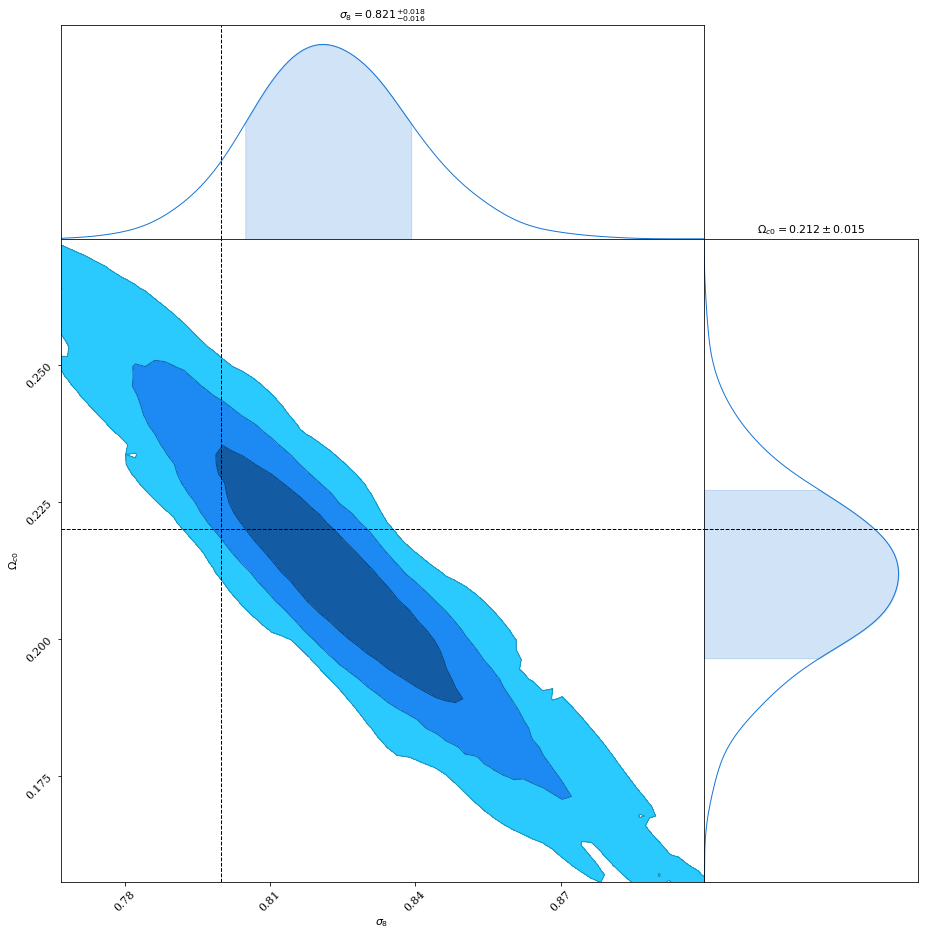

In [21]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

nwalkers = mcat.nchains ()
m2lnL = mcat.get_m2lnp_var ()

rows = np.array ([mcat.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]

posterior = -0.5 * rows[:,m2lnL]

rows   = np.delete (rows,   m2lnL, 1)
params = np.delete (params, m2lnL, 0)

indices = [0,2]

rows   = rows[:,indices]
params = params[indices]

c.add_chain(rows, posterior = posterior, parameters=list(params))
c.configure (kde = True, label_font_size=11, sigma2d=False, sigmas = [1, 2, 3], spacing = 0.0, tick_font_size=11, usetex=False)

plot_args = {}
plot_args['truth'] = [cosmo_ss.sigma8, cosmo_ss.Odm0]

fig = c.plotter.plot(**plot_args)

fig.set_size_inches(14.0, 14.0)
